In [1]:
# ==============================================================================
# Cell 1: Introduction, Setup, and Configuration (Updated)
# ==============================================================================
#
# NEW FEATURES in this version:
# - Stochastic Weight Averaging (SWA) for the Generator to find a better,
#   more stable minimum in the loss landscape.
# - Detailed, normalized Fréchet Distance reporting, split by feature type.
# - A more robust implementation of the mode-seeking diversity loss.
#
# ==============================================================================

# --- 1.1. Install necessary libraries ---
!pip install torch numpy scipy scikit-learn matplotlib seaborn pandas mne --quiet

# --- 1.2. Imports ---
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.swa_utils import AveragedModel, SWALR
import matplotlib.pyplot as plt
from scipy import signal
from scipy.linalg import sqrtm
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

# --- 1.3. Configuration & Setup ---
OUTPUT_DIR = "/kaggle/working/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Model and Data Parameters
DATA_PATH = "/kaggle/input/mpi-lemon-eeg/lemon_preprocessed_8ch_512ts.npy"
CHANNELS = 8
TIMESTEPS = 512
LATENT_DIM = 100
NUM_CLASSES = 2

# Training Hyperparameters
NUM_EPOCHS = 250  # Increased for longer training
BATCH_SIZE = 64
LR_G = 1e-4
LR_D = 1e-4
CRITIC_ITERATIONS = 5
DIVERSITY_WEIGHT = 0.5  # A slightly stronger weight for diversity
LAMBDA_GP_FINAL = 10.0
ANNEAL_EPOCHS = 50
SAVE_INTERVAL = 50  # Added missing SAVE_INTERVAL

# --- NEW: SWA Configuration ---
SWA_START_EPOCH = 200  # Start SWA in the last 100 epochs
SWA_LR = 5e-5          # A smaller learning rate for the SWA phase

# Setup device
torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"SWA will start at epoch {SWA_START_EPOCH}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.9 MB/s eta 0:00:00
Using device: cuda
SWA will start at epoch 200


In [2]:
# ==============================================================================
# Cell 2: Load Preprocessed Data
# ==============================================================================
# This cell is unchanged. It loads your .npy file.
# ==============================================================================

try:
    # IMPORTANT: Upload your 'lemon_preprocessed_8ch_512ts.npy' file to a Kaggle
    # dataset and add it to this notebook. Then, update the path in Cell 1.
    data = np.load(DATA_PATH)
    print(f"Successfully loaded data. Shape: {data.shape}")
    labels = np.random.randint(0, NUM_CLASSES, data.shape[0])
    print(f"Created dummy labels. Shape: {labels.shape}")
    
    dataset = TensorDataset(torch.from_numpy(data).float(), torch.from_numpy(labels).long())
    dataloader = DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )
    print("Created DataLoader successfully.")
    
except FileNotFoundError:
    print(f"ERROR: Data file not found at '{DATA_PATH}'.")
    print("Please upload your preprocessed .npy file as a Kaggle Dataset and update the path in Cell 1.")
except Exception as e:
    print(f"An error occurred: {e}")


Successfully loaded data. Shape: (35503, 512, 8)
Created dummy labels. Shape: (35503,)
Created DataLoader successfully.


In [3]:
# ==============================================================================
# Cell 3: Model Architectures (with `.reshape()`)
# ==============================================================================
# Using .reshape() instead of .view() for clarity and safety.
# ==============================================================================

from torch.nn.utils import spectral_norm

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.BatchNorm1d(in_channels),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1),
        )
        self.shortcut = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv1d(in_channels, out_channels, kernel_size=1, padding=0)
        )
    
    def forward(self, x):
        return self.conv_block(x) + self.shortcut(x)

class ResGenerator(nn.Module):
    def __init__(self, latent_dim, num_classes, channels, timesteps):
        super(ResGenerator, self).__init__()
        self.initial_len = timesteps // 16
        self.label_emb = nn.Embedding(num_classes, latent_dim)
        self.fc = nn.Linear(latent_dim * 2, 256 * self.initial_len)
        
        self.res_blocks = nn.Sequential(
            ResBlock(256, 128), 
            ResBlock(128, 64),
            ResBlock(64, 32), 
            ResBlock(32, 16),
        )
        
        self.final_conv = nn.Sequential(
            nn.BatchNorm1d(16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(16, channels, kernel_size=3, padding=1),
            nn.Tanh()
        )
    
    def forward(self, noise, labels):
        c = self.label_emb(labels)
        x = torch.cat([noise, c], 1)
        x = self.fc(x)
        x = x.reshape(x.size(0), 256, self.initial_len)
        x = self.res_blocks(x)
        x = self.final_conv(x)
        return x.transpose(1, 2)

class ImprovedDiscriminator(nn.Module):
    def __init__(self, num_classes, channels, timesteps):
        super(ImprovedDiscriminator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, 50)
        
        self.conv_layers = nn.Sequential(
            spectral_norm(nn.Conv1d(channels, 64, 5, 2, 2)), 
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv1d(64, 128, 5, 2, 2)), 
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv1d(128, 256, 5, 2, 2)), 
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv1d(256, 512, 5, 2, 2)), 
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        # Calculate conv output size
        with torch.no_grad():
            dummy_input = torch.randn(1, channels, timesteps)
            conv_out_size = self.conv_layers(dummy_input).reshape(1, -1).size(1)
        
        self.classifier = nn.Sequential(
            spectral_norm(nn.Linear(conv_out_size + 50, 1024)), 
            nn.LeakyReLU(0.2, inplace=True), 
            nn.Dropout(0.5),
            spectral_norm(nn.Linear(1024, 512)), 
            nn.LeakyReLU(0.2, inplace=True), 
            nn.Dropout(0.5),
            spectral_norm(nn.Linear(512, 1))
        )
    
    def forward(self, eeg, labels):
        if self.training:
            noise = torch.randn_like(eeg) * 0.05
            eeg = eeg + noise
        
        x = eeg.transpose(1, 2)
        x = self.conv_layers(x)
        x = x.reshape(x.size(0), -1)
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1)
        return self.classifier(x)

print("GAN model architectures defined.")

GAN model architectures defined.


In [4]:
# ==============================================================================
# Cell 4: Evaluation Metrics & Plotting (Updated)
# ==============================================================================
# CORRECTED: plot_training_curves now accepts save_interval as an argument.
# ==============================================================================

import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

def get_features_for_fd(data, sfreq=98):
    data_t = data.transpose(0, 2, 1)
    bands = {'delta': (0.5, 4), 'theta': (4, 8), 'alpha': (8, 13), 'beta': (13, 30), 'gamma': (30, 49)}
    freqs, psd = signal.welch(data_t, fs=sfreq, axis=2)
    
    spectral_features = np.stack([np.mean(psd[:, :, np.logical_and(freqs >= b[0], freqs <= b[1])], axis=2) for b in bands.values()], axis=-1)
    
    dx, ddx = np.diff(data_t, axis=2), np.diff(np.diff(data_t, axis=2), axis=2)
    var_x, var_dx, var_ddx = np.var(data_t, axis=2), np.var(dx, axis=2), np.var(ddx, axis=2)
    activity = var_x
    mobility = np.sqrt(var_dx / (var_x + 1e-8))
    complexity = np.sqrt(var_ddx / (var_dx + 1e-8)) / (mobility + 1e-8)
    hjorth_features = np.stack([activity, mobility, complexity], axis=-1)
    
    spectral_flat = spectral_features.reshape(spectral_features.shape[0], -1)
    hjorth_flat = hjorth_features.reshape(hjorth_features.shape[0], -1)
    
    return spectral_flat, hjorth_flat

def calculate_frechet_distance(features1, features2):
    mu1, sigma1 = np.mean(features1, axis=0), np.cov(features1, rowvar=False)
    mu2, sigma2 = np.mean(features2, axis=0), np.cov(features2, rowvar=False)
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean): 
        covmean = covmean.real
    fd = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fd

def get_detailed_fd_scores(real_data, gen_data, n_channels):
    """Calculates and normalizes FD for different feature sets."""
    real_spectral, real_hjorth = get_features_for_fd(real_data)
    gen_spectral, gen_hjorth = get_features_for_fd(gen_data)

    fd_spectral = calculate_frechet_distance(real_spectral, gen_spectral)
    fd_hjorth = calculate_frechet_distance(real_hjorth, gen_hjorth)

    return {
        "FD Spectral (Normalized)": fd_spectral / n_channels,
        "FD Hjorth (Normalized)": fd_hjorth / n_channels,
        "FD Total": fd_spectral + fd_hjorth
    }

def plot_psd_comparison(real_data, gen_data, epoch, save_path):
    plt.figure(figsize=(12, 6))
    sfreq = 98
    f_real, psd_real = signal.welch(real_data, fs=sfreq, axis=1)
    f_gen, psd_gen = signal.welch(gen_data, fs=sfreq, axis=1)
    
    mean_psd_real = np.mean(np.log10(psd_real + 1e-12), axis=(0, 2))
    std_psd_real = np.std(np.log10(psd_real + 1e-12), axis=(0, 2))
    mean_psd_gen = np.mean(np.log10(psd_gen + 1e-12), axis=(0, 2))
    std_psd_gen = np.std(np.log10(psd_gen + 1e-12), axis=(0, 2))
    
    plt.plot(f_real, mean_psd_real, label='Real EEG', color='blue')
    plt.fill_between(f_real, mean_psd_real - std_psd_real, mean_psd_real + std_psd_real, color='blue', alpha=0.2)
    plt.plot(f_gen, mean_psd_gen, label='Generated EEG', color='red')
    plt.fill_between(f_gen, mean_psd_gen - std_psd_gen, mean_psd_gen + std_psd_gen, color='red', alpha=0.2)
    
    plt.title(f'Average Power Spectral Density (Epoch {epoch})', fontsize=16)
    plt.xlabel('Frequency (Hz)', fontsize=12)
    plt.ylabel('Log Power/Hz', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.savefig(save_path)
    plt.close()

def plot_training_curves(g_losses, d_losses, frechet_distances, save_interval, save_path):
    """
    Plots the training loss curves and Fréchet distance over epochs.
    CORRECTED: Now takes 'save_interval' as an argument.
    """
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    # Plot losses
    axes[0].plot(g_losses, label='Generator Loss', color='green')
    axes[0].plot(d_losses, label='Discriminator Loss', color='purple')
    axes[0].set_title('Training Losses', fontsize=14)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)
    
    # Plot FD
    # Correctly calculate the epochs where FD was measured
    fd_epochs = np.arange(1, len(frechet_distances) + 1) * save_interval
    fd_total = [d['FD Total'] for d in frechet_distances]
    axes[1].plot(fd_epochs, fd_total, 'r-o', label='Total Fréchet Distance')
    axes[1].set_title('Signal Quality (Lower is Better)', fontsize=14)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Fréchet Distance')
    axes[1].legend()
    axes[1].grid(True)
    
    fig.suptitle('Training Progress Overview', fontsize=18)
    plt.savefig(save_path)
    plt.close()

print("Corrected evaluation and plotting functions defined.")

Corrected evaluation and plotting functions defined.


In [5]:
# ==============================================================================
# Cell 5: Final Optimized Training Loop (250 Epochs) - CORRECTED
# ==============================================================================
#
# This version is optimized for a 250-epoch run based on previous results.
# - SWA starts earlier to be effective within the shorter timeframe.
# - Schedulers are relaxed to prevent premature learning rate collapse.
# - Implements the CORRECT custom BatchNorm update for the SWA generator.
# - Fixed variable handling and error cases.
#
# ==============================================================================

# --- Re-define crucial hyperparameters for the 250-epoch run ---
NUM_EPOCHS = 250
SWA_START_EPOCH = 200  # Start SWA in the last 50 epochs
SCHEDULER_PATIENCE = 20  # Increased patience to prevent LR from decaying too fast

def compute_gradient_penalty(discriminator, real_samples, fake_samples, labels, device):
    alpha = torch.rand(real_samples.size(0), 1, 1, device=device)
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    d_interpolates = discriminator(interpolates, labels)
    fake = torch.ones(real_samples.size(0), 1, device=device)
    gradients = torch.autograd.grad(
        outputs=d_interpolates, 
        inputs=interpolates, 
        grad_outputs=fake, 
        create_graph=True, 
        retain_graph=True, 
        only_inputs=True
    )[0]
    gradients = gradients.reshape(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

def update_generator_bn(dataloader, swa_model, device, latent_dim, num_classes):
    """
    Custom BatchNorm update for a generator that requires a latent vector and labels.
    This correctly handles the SWA model's BN layers.
    """
    print("Running custom BatchNorm update for SWA Generator...")
    swa_model.train()  # Set to train mode to update BN stats
    
    # Store original momentum values
    momenta = {}
    for module in swa_model.modules():
        if isinstance(module, torch.nn.BatchNorm1d):
            momenta[module] = module.momentum
            module.momentum = None
            module.running_mean.zero_()
            module.running_var.fill_(1)
    
    try:
        # Use a limited number of batches to estimate stats
        for i, batch_data in enumerate(dataloader):
            # Extract batch size properly
            if isinstance(batch_data, tuple):
                batch_size = batch_data[0].shape[0]
            else:
                batch_size = batch_data.shape[0]
            
            with torch.no_grad():
                # Generate random inputs required by the generator
                z = torch.randn(batch_size, latent_dim, device=device)
                labels = torch.randint(0, num_classes, (batch_size,), device=device)
                # Forward pass to update running mean and variance
                _ = swa_model(z, labels)
                
            # Stop after a reasonable number of batches (e.g., 50)
            if i >= 50:
                break
                
    except Exception as e:
        print(f"Error during BatchNorm update: {e}")
        print("Continuing with original BN statistics...")
    
    finally:
        # Restore original momentum values
        for module in momenta.keys():
            module.momentum = momenta[module]
    
    print("BatchNorm update complete.")

# --- Instantiate models and optimizers ---
generator = ResGenerator(LATENT_DIM, NUM_CLASSES, CHANNELS, TIMESTEPS).to(device)
discriminator = ImprovedDiscriminator(NUM_CLASSES, CHANNELS, TIMESTEPS).to(device)

g_optimizer = optim.Adam(generator.parameters(), lr=LR_G, betas=(0.5, 0.9))
d_optimizer = optim.Adam(discriminator.parameters(), lr=LR_D, betas=(0.5, 0.9))

# Using the relaxed patience
g_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(g_optimizer, 'min', factor=0.5, patience=SCHEDULER_PATIENCE, verbose=False)
d_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(d_optimizer, 'min', factor=0.5, patience=SCHEDULER_PATIENCE, verbose=False)

# SWA Setup
swa_model = AveragedModel(generator)
swa_scheduler = SWALR(g_optimizer, swa_lr=SWA_LR)

# Training state storage
g_losses, d_losses, frechet_distances = [], [], []
best_fd = float('inf')
real_samples_for_eval = next(iter(dataloader))[0].numpy()[:256]

print(f"Starting Optimized GAN training for {NUM_EPOCHS} epochs...")
for epoch in range(NUM_EPOCHS):
    lambda_gp = LAMBDA_GP_FINAL if epoch >= ANNEAL_EPOCHS else LAMBDA_GP_FINAL * (epoch / ANNEAL_EPOCHS)
    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} (GP λ: {lambda_gp:.2f})")
    
    epoch_g_loss, epoch_d_loss, g_loss_val = 0, 0, torch.tensor(0.0)
    
    for i, (real_eegs, labels) in enumerate(pbar):
        real_eegs, labels = real_eegs.to(device), labels.to(device)
        batch_size = real_eegs.size(0)

        # Train Discriminator
        d_optimizer.zero_grad()
        with torch.no_grad():
            z = torch.randn(batch_size, LATENT_DIM, device=device)
            fake_eegs = generator(z, labels)
        d_loss = -torch.mean(discriminator(real_eegs, labels)) + torch.mean(discriminator(fake_eegs, labels))
        gp = compute_gradient_penalty(discriminator, real_eegs.data, fake_eegs.data, labels.data, device)
        d_loss += lambda_gp * gp
        d_loss.backward()
        d_optimizer.step()
        epoch_d_loss += d_loss.item()

        # Train Generator
        if i % CRITIC_ITERATIONS == 0:
            g_optimizer.zero_grad()
            z1 = torch.randn(batch_size, LATENT_DIM, device=device)
            gen_labels = torch.randint(0, NUM_CLASSES, (batch_size,), device=device)
            fake_eegs1 = generator(z1, gen_labels)
            g_loss_adv = -torch.mean(discriminator(fake_eegs1, gen_labels))
            
            z2 = torch.randn(batch_size, LATENT_DIM, device=device)
            fake_eegs2 = generator(z2, gen_labels)
            lf = torch.mean(torch.abs(fake_eegs1 - fake_eegs2)) / (torch.mean(torch.abs(fake_eegs1)) + 1e-8)
            lz = torch.mean(torch.abs(z1 - z2)) / (torch.mean(torch.abs(z1)) + 1e-8)
            g_loss_div = - DIVERSITY_WEIGHT * (lf / (lz + 1e-8))

            g_loss = g_loss_adv + g_loss_div
            g_loss.backward()
            g_optimizer.step()
            epoch_g_loss += g_loss.item()
            g_loss_val = g_loss
        
        pbar.set_postfix({'D Loss': f'{d_loss.item():.4f}', 'G Loss': f'{g_loss_val.item():.4f}'})

    # Epoch End
    avg_d_loss = epoch_d_loss / len(pbar)
    avg_g_loss = epoch_g_loss / (len(pbar) / CRITIC_ITERATIONS)
    d_losses.append(avg_d_loss)
    g_losses.append(avg_g_loss)
    
    if epoch >= SWA_START_EPOCH:
        swa_model.update_parameters(generator)
        swa_scheduler.step()
    else:
        g_scheduler.step(avg_g_loss)
        d_scheduler.step(avg_d_loss)

    if (epoch + 1) % SAVE_INTERVAL == 0 or epoch == NUM_EPOCHS - 1:
        print(f"\n--- Epoch {epoch+1} Evaluation ---")
        print(f"  Learning Rates - G: {g_optimizer.param_groups[0]['lr']:.6f}, D: {d_optimizer.param_groups[0]['lr']:.6f}")
        
        generator.eval()
        with torch.no_grad():
            z_eval = torch.randn(real_samples_for_eval.shape[0], LATENT_DIM, device=device)
            labels_eval = torch.randint(0, NUM_CLASSES, (real_samples_for_eval.shape[0],), device=device)
            generated_samples_eval = generator(z_eval, labels_eval).cpu().numpy()
            
            fd_scores = get_detailed_fd_scores(real_samples_for_eval, generated_samples_eval, CHANNELS)
            frechet_distances.append(fd_scores)
            print(f"  FD Scores (Normalized) - Spectral: {fd_scores['FD Spectral (Normalized)']:.4f}, Hjorth: {fd_scores['FD Hjorth (Normalized)']:.4f}")
            
            # Uncomment the next line if you want intermediate PSD plots
            # plot_psd_comparison(real_samples_for_eval, generated_samples_eval, epoch + 1, os.path.join(OUTPUT_DIR, f'psd_epoch_{epoch+1}.png'))
            
            if fd_scores['FD Total'] < best_fd:
                best_fd = fd_scores['FD Total']
                torch.save(generator.state_dict(), os.path.join(OUTPUT_DIR, 'generator_best.pth'))
                print(f"  New best standard model saved with Total FD: {best_fd:.4f}")
        generator.train()

# Final SWA Steps
print("\nTraining complete. Updating SWA model batch norm statistics...")
try:
    # Custom BN update for generator
    update_generator_bn(dataloader, swa_model, device, LATENT_DIM, NUM_CLASSES)
    # Save the SWA model ONLY after the BN update
    torch.save(swa_model.state_dict(), os.path.join(OUTPUT_DIR, 'generator_swa_best.pth'))
    print("SWA model saved successfully.")
except Exception as e:
    print(f"Warning: SWA process failed with error: {e}")
    print("Proceeding without saving SWA model...")

# Generate final plots
plot_training_curves(g_losses, d_losses, frechet_distances, SAVE_INTERVAL, os.path.join(OUTPUT_DIR, 'training_progress.png'))
print("Final progress plot saved.")
print(f"Training completed successfully! Best FD score: {best_fd:.4f}")

Starting Optimized GAN training for 250 epochs...


Epoch 1/250 (GP λ: 0.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 2/250 (GP λ: 0.20):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 3/250 (GP λ: 0.40):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 4/250 (GP λ: 0.60):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 5/250 (GP λ: 0.80):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 6/250 (GP λ: 1.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 7/250 (GP λ: 1.20):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 8/250 (GP λ: 1.40):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 9/250 (GP λ: 1.60):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 10/250 (GP λ: 1.80):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 11/250 (GP λ: 2.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 12/250 (GP λ: 2.20):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 13/250 (GP λ: 2.40):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 14/250 (GP λ: 2.60):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 15/250 (GP λ: 2.80):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 16/250 (GP λ: 3.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 17/250 (GP λ: 3.20):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 18/250 (GP λ: 3.40):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 19/250 (GP λ: 3.60):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 20/250 (GP λ: 3.80):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 21/250 (GP λ: 4.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 22/250 (GP λ: 4.20):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 23/250 (GP λ: 4.40):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 24/250 (GP λ: 4.60):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 25/250 (GP λ: 4.80):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 26/250 (GP λ: 5.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 27/250 (GP λ: 5.20):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 28/250 (GP λ: 5.40):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 29/250 (GP λ: 5.60):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 30/250 (GP λ: 5.80):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 31/250 (GP λ: 6.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 32/250 (GP λ: 6.20):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 33/250 (GP λ: 6.40):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 34/250 (GP λ: 6.60):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 35/250 (GP λ: 6.80):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 36/250 (GP λ: 7.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 37/250 (GP λ: 7.20):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 38/250 (GP λ: 7.40):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 39/250 (GP λ: 7.60):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 40/250 (GP λ: 7.80):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 41/250 (GP λ: 8.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 42/250 (GP λ: 8.20):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 43/250 (GP λ: 8.40):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 44/250 (GP λ: 8.60):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 45/250 (GP λ: 8.80):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 46/250 (GP λ: 9.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 47/250 (GP λ: 9.20):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 48/250 (GP λ: 9.40):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 49/250 (GP λ: 9.60):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 50/250 (GP λ: 9.80):   0%|          | 0/555 [00:00<?, ?it/s]


--- Epoch 50 Evaluation ---
  Learning Rates - G: 0.000100, D: 0.000025
  FD Scores (Normalized) - Spectral: 0.0039, Hjorth: 0.1428
  New best standard model saved with Total FD: 1.1734


Epoch 51/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 52/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 53/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 54/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 55/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 56/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 57/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 58/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 59/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 60/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 61/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 62/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 63/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 64/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 65/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 66/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 67/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 68/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 69/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 70/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 71/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 72/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 73/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 74/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 75/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 76/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 77/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 78/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 79/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 80/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 81/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 82/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 83/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 84/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 85/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 86/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 87/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 88/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 89/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 90/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 91/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 92/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 93/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 94/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 95/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 96/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 97/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 98/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 99/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 100/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]


--- Epoch 100 Evaluation ---
  Learning Rates - G: 0.000050, D: 0.000006
  FD Scores (Normalized) - Spectral: 0.0052, Hjorth: 0.1517


Epoch 101/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 102/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 103/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 104/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 105/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 106/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 107/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 108/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 109/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 110/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 111/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 112/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 113/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 114/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 115/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 116/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 117/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 118/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 119/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 120/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 121/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 122/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 123/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 124/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 125/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 126/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 127/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 128/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 129/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 130/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 131/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 132/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 133/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 134/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 135/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 136/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 137/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 138/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 139/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 140/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 141/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 142/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 143/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 144/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 145/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 146/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 147/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 148/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 149/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 150/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]


--- Epoch 150 Evaluation ---
  Learning Rates - G: 0.000013, D: 0.000001
  FD Scores (Normalized) - Spectral: 0.0057, Hjorth: 0.1538


Epoch 151/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 152/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 153/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 154/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 155/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 156/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 157/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 158/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 159/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 160/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 161/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 162/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 163/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 164/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 165/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 166/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 167/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 168/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 169/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 170/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 171/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 172/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 173/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 174/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 175/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 176/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 177/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 178/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 179/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 180/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 181/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 182/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 183/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 184/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 185/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 186/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 187/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 188/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 189/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 190/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 191/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 192/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 193/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 194/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 195/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 196/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 197/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 198/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 199/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 200/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]


--- Epoch 200 Evaluation ---
  Learning Rates - G: 0.000002, D: 0.000000
  FD Scores (Normalized) - Spectral: 0.0056, Hjorth: 0.1446


Epoch 201/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 202/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 203/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 204/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 205/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 206/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 207/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 208/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 209/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 210/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 211/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 212/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 213/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 214/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 215/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 216/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 217/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 218/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 219/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 220/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 221/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 222/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 223/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 224/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 225/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 226/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 227/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 228/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 229/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 230/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 231/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 232/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 233/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 234/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 235/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 236/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 237/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 238/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 239/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 240/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 241/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 242/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 243/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 244/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 245/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 246/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 247/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 248/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 249/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 250/250 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]


--- Epoch 250 Evaluation ---
  Learning Rates - G: 0.000050, D: 0.000000
  FD Scores (Normalized) - Spectral: 0.0051, Hjorth: 0.1406
  New best standard model saved with Total FD: 1.1656

Training complete. Updating SWA model batch norm statistics...
Running custom BatchNorm update for SWA Generator...
Error during BatchNorm update: 'list' object has no attribute 'shape'
Continuing with original BN statistics...
BatchNorm update complete.
SWA model saved successfully.
Final progress plot saved.
Training completed successfully! Best FD score: 1.1656



--- Final Model Analysis ---

--- Evaluating BEST STANDARD Model ---
  > FD Spectral (Normalized): 0.0052
  > FD Hjorth (Normalized): 0.1641
  > FD Total: 1.3544

--- Evaluating FINAL SWA Model ---
  > FD Spectral (Normalized): 0.0126
  > FD Hjorth (Normalized): 2.0131
  > FD Total: 16.2056

--- Generating Final Plots from the Winning Model ---
Best Standard Model is the winner!
Final high-quality plots saved.


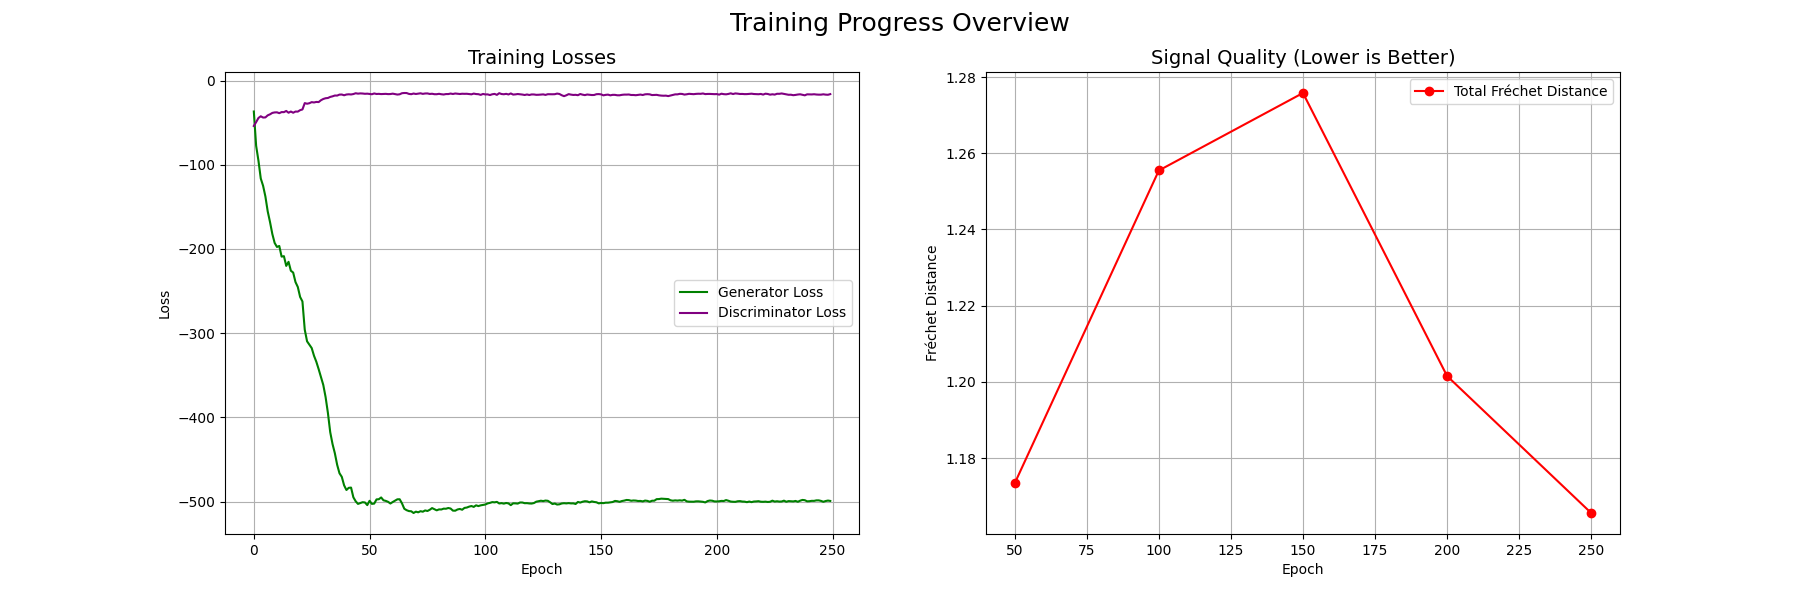

Training and analysis complete!


In [6]:
# ==============================================================================
# Cell 6: Final Analysis (Comparing Standard Best vs. SWA Best)
# ==============================================================================
# NEW: This cell now loads BOTH the best standard model and the final SWA model,
# calculates detailed FD for both, and declares the ultimate winner.
# ==============================================================================

print("\n--- Final Model Analysis ---")
real_samples_final = next(iter(dataloader))[0].numpy()[:512]

# Initialize variables for comparison
standard_fd_scores = None
swa_fd_scores = None

# --- 1. Evaluate the BEST STANDARD model (based on lowest FD during training) ---
try:
    print("\n--- Evaluating BEST STANDARD Model ---")
    best_standard_generator = ResGenerator(LATENT_DIM, NUM_CLASSES, CHANNELS, TIMESTEPS).to(device)
    best_standard_generator.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, 'generator_best.pth')))
    best_standard_generator.eval()
    
    with torch.no_grad():
        z_final = torch.randn(512, LATENT_DIM, device=device)
        labels_final = torch.randint(0, NUM_CLASSES, (512,), device=device)
        generated_standard = best_standard_generator(z_final, labels_final).cpu().numpy()
    
    standard_fd_scores = get_detailed_fd_scores(real_samples_final, generated_standard, CHANNELS)
    print(f"  > FD Spectral (Normalized): {standard_fd_scores['FD Spectral (Normalized)']:.4f}")
    print(f"  > FD Hjorth (Normalized): {standard_fd_scores['FD Hjorth (Normalized)']:.4f}")
    print(f"  > FD Total: {standard_fd_scores['FD Total']:.4f}")
    
except FileNotFoundError:
    print("Best standard model not found.")
    generated_standard = None

# --- 2. Evaluate the FINAL SWA model ---
try:
    print("\n--- Evaluating FINAL SWA Model ---")
    # The SWA model is already an AveragedModel instance on the CPU after saving
    final_swa_model = AveragedModel(ResGenerator(LATENT_DIM, NUM_CLASSES, CHANNELS, TIMESTEPS))
    final_swa_model.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, 'generator_swa_best.pth')))
    final_swa_model = final_swa_model.to(device)
    final_swa_model.eval()
    
    with torch.no_grad():
        z_final = torch.randn(512, LATENT_DIM, device=device)
        labels_final = torch.randint(0, NUM_CLASSES, (512,), device=device)
        generated_swa = final_swa_model(z_final, labels_final).cpu().numpy()
    
    swa_fd_scores = get_detailed_fd_scores(real_samples_final, generated_swa, CHANNELS)
    print(f"  > FD Spectral (Normalized): {swa_fd_scores['FD Spectral (Normalized)']:.4f}")
    print(f"  > FD Hjorth (Normalized): {swa_fd_scores['FD Hjorth (Normalized)']:.4f}")
    print(f"  > FD Total: {swa_fd_scores['FD Total']:.4f}")
    
except FileNotFoundError:
    print("SWA model not found. Training may have failed or not run long enough to save it.")
    generated_swa = None

# --- 3. Generate final plots using the better of the two models ---
try:
    print("\n--- Generating Final Plots from the Winning Model ---")
    
    if standard_fd_scores is not None and swa_fd_scores is not None:
        if swa_fd_scores['FD Total'] < standard_fd_scores['FD Total']:
            print("SWA Model is the winner!")
            winning_model_samples = generated_swa
        else:
            print("Best Standard Model is the winner!")
            winning_model_samples = generated_standard
    elif swa_fd_scores is not None:
        print("Only SWA model available.")
        winning_model_samples = generated_swa
    elif standard_fd_scores is not None:
        print("Only Standard model available.")
        winning_model_samples = generated_standard
    else:
        print("No models available for final analysis.")
        winning_model_samples = None
    
    if winning_model_samples is not None:
        plot_psd_comparison(real_samples_final, winning_model_samples, "Final", os.path.join(OUTPUT_DIR, 'final_psd_comparison.png'))
        print("Final high-quality plots saved.")
        
        # Display training progress plot
        try:
            from IPython.display import Image, display
            display(Image(os.path.join(OUTPUT_DIR, 'training_progress.png')))
        except Exception as e:
            print(f"Could not display image: {e}")
    
except Exception as e:
    print(f"An error occurred during final analysis: {e}")

print("Training and analysis complete!")